In [1]:
# import pandas for data handling
import pandas as pd

# import numpy for numerical operations
import numpy as np

In [2]:
# import matplotlib for data visualization
import matplotlib.pyplot as plt

# import function to split data into train and test sets
from sklearn.model_selection import train_test_split

# import DecisionTreeClassifier model
from sklearn.tree import DecisionTreeClassifier

# import accuracy_score to evaluate predictions
from sklearn.metrics import accuracy_score

# import function for cross validation
from sklearn.model_selection import cross_val_score

# import KBinsDiscretizer to convert continuous data into bins
from sklearn.preprocessing import KBinsDiscretizer

# import ColumnTransformer to apply column wise transformations
from sklearn.compose import ColumnTransformer

In [3]:
# load selected columns from csv file into dataframe
df = pd.read_csv('train.csv', usecols=['Age', 'Fare', 'Survived'])

In [4]:
# remove rows with missing values
df.dropna(inplace=True)

In [5]:
# show number of rows and columns after removing missing values
df.shape

(714, 3)

In [6]:
# display first 5 rows of dataframe
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [7]:
# split data into features and target
# x contains Fare and Survived columns
# y contains Age column
x = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [8]:
# split data into train and test sets
# 80% train and 20% test
# random_state=42 keeps split reproducible
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [9]:
# display first 2 rows of dataframe
df.head(2)

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833


## **Without Binning**

In [10]:
# initialize DecisionTreeClassifier model
clf = DecisionTreeClassifier()

# train model using training data
clf.fit(x_train, y_train)

# predict target values for test data
y_pred = clf.predict(x_test)

# calculate accuracy of the model
accuracy_score(y_test, y_pred)

0.6363636363636364

In [11]:
# perform 10 fold cross validation using DecisionTreeClassifier
# calculate accuracy for each fold
# take mean of all accuracy scores
np.mean(cross_val_score(DecisionTreeClassifier(), x, y, cv=10, scoring='accuracy'))

np.float64(0.6303012519561814)

## **Applying Binning**

In [12]:
# create KBinsDiscretizer for Age column
# discretize Age into 15 quantile based bins
kbin_age = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='quantile')

# create KBinsDiscretizer for Fare column
# discretize Fare into 15 quantile based bins
kbin_fare = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='quantile')

In [13]:
# apply different kbin transformers using ColumnTransformer
# Age is transformed using kbin_age
# Fare is transformed using kbin_fare
trf = ColumnTransformer([
    ('first', kbin_age, ['Age']),
    ('second', kbin_fare, ['Fare'])
])

In [14]:
# display ColumnTransformer object
trf

ColumnTransformer(transformers=[('first',
                                 KBinsDiscretizer(encode='ordinal', n_bins=15),
                                 ['Age']),
                                ('second',
                                 KBinsDiscretizer(encode='ordinal', n_bins=15),
                                 ['Fare'])])

In [15]:
# fit ColumnTransformer on training data and transform
x_train_trf = trf.fit_transform(x_train)

# apply same transformation to test data
x_test_trf = trf.transform(x_test)

In [16]:
# get bin edges for Age column from kbin transformer
trf.named_transformers_['first'].bin_edges_

array([array([ 0.42,  6.  , 16.  , 19.  , 21.  , 23.  , 25.  , 28.  , 30.  ,
              32.  , 35.  , 38.  , 42.  , 47.  , 54.  , 80.  ])             ],
      dtype=object)

In [17]:
# get bin edges for Fare column from kbin transformer
trf.named_transformers_['second'].bin_edges_

array([array([  0.    ,   7.25  ,   7.775 ,   7.8958,   8.1583,  10.5   ,
               13.    ,  14.4542,  18.75  ,  26.    ,  26.55  ,  31.275 ,
               51.4792,  76.2917, 108.9   , 512.3292])                   ],
      dtype=object)

In [18]:
# create dataframe to compare original and transformed Age and Fare
output = pd.DataFrame({
    'age_original': x_train['Age'],           # original Age values
    'age_transformed': x_train_trf[:, 0],     # binned Age values
    'fare_original': x_train['Fare'],         # original Fare values
    'fare_transformed': x_train_trf[:, 1]     # binned Fare values
})

In [19]:
# assign bin labels to Age values using bin edges from transformer
output['age_labels'] = pd.cut(
    x=x_train['Age'],
    bins=trf.named_transformers_['first'].bin_edges_[0].tolist()
)

# assign bin labels to Fare values using bin edges from transformer
output['fare_labels'] = pd.cut(
    x=x_train['Fare'],
    bins=trf.named_transformers_['second'].bin_edges_[0].tolist()
)

In [20]:
# display 5 random rows to check bin labels and transformed values
output.sample(5)

,age_original,age_transformed,fare_original,fare_transformed,age_labels,fare_labels
699,42.0,12.0,7.6500,1.0,"(38.0, 42.0]","(7.25, 7.775]"
887,19.0,3.0,30.0000,10.0,"(16.0, 19.0]","(26.55, 31.275]"
73,26.0,6.0,14.4542,7.0,"(25.0, 28.0]","(13.0, 14.454]"
695,52.0,13.0,13.5000,6.0,"(47.0, 54.0]","(13.0, 14.454]"
765,51.0,13.0,77.9583,13.0,"(47.0, 54.0]","(76.292, 108.9]"


**The labels here are interval numbers where the data lies**

In [21]:
# train DecisionTreeClassifier on discretized training data
clf = DecisionTreeClassifier()
clf.fit(x_train_trf, y_train)

# predict target values for test data
y_pred2 = clf.predict(x_test_trf)

# calculate accuracy of model on test data
accuracy_score(y_test, y_pred2)

0.6363636363636364

In [22]:
# apply column transformer to full feature dataset
x_trf = trf.fit_transform(x)

# perform 10 fold cross validation using DecisionTreeClassifier
# calculate average accuracy across all folds
np.mean(cross_val_score(DecisionTreeClassifier(), x_trf, y, cv=10, scoring='accuracy'))

np.float64(0.6723004694835681)

## **Showcasing Multiple Discretization**

In [23]:
# function to discretize Age and Fare columns using given bins and strategy
# fits DecisionTreeClassifier and shows cross-validation accuracy
# also visualizes distributions before and after binning
def discretize(bins, strategy):
    # create KBinsDiscretizer for Age
    kbin_age = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy)
    # create KBinsDiscretizer for Fare
    kbin_fare = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy)

    # combine both transformers into a ColumnTransformer
    trf = ColumnTransformer([
        ('first', kbin_age, ['Age']),
        ('second', kbin_fare, ['Fare'])
    ])

    # apply transformation to full dataset
    x_trf = trf.fit_transform(x)

    # print cross-validation accuracy without transformation for comparison
    print(np.mean(cross_val_score(DecisionTreeClassifier(), x, y, cv=10, scoring='accuracy')))

    # plot Age distribution before and after binning
    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.hist(x['Age'])
    plt.title('Age - before')

    plt.subplot(122)
    plt.hist(x_trf[:, 0], color='red')
    plt.title('Age - after')

    plt.show()

    # plot Fare distribution before and after binning
    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.hist(x['Fare'])
    plt.title('Fare - before')

    plt.subplot(122)
    plt.hist(x_trf[:, 1], color='red')
    plt.title('Fare - after')

    plt.show()

0.6373043818466353


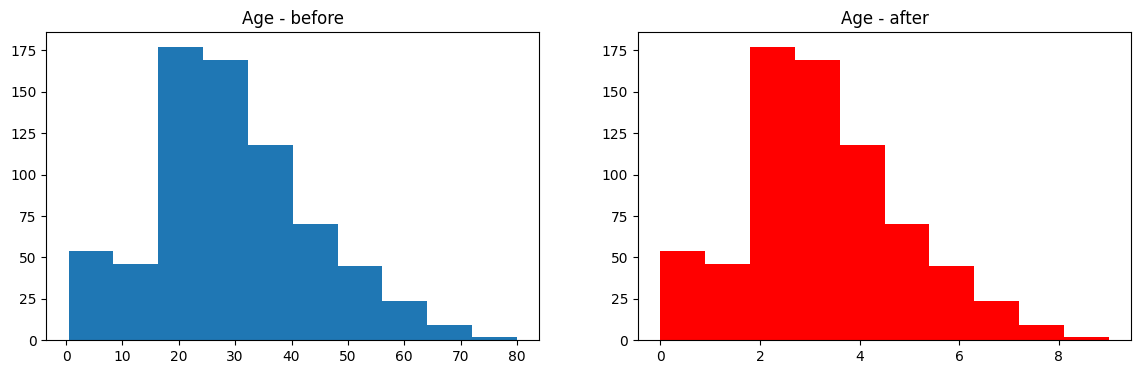

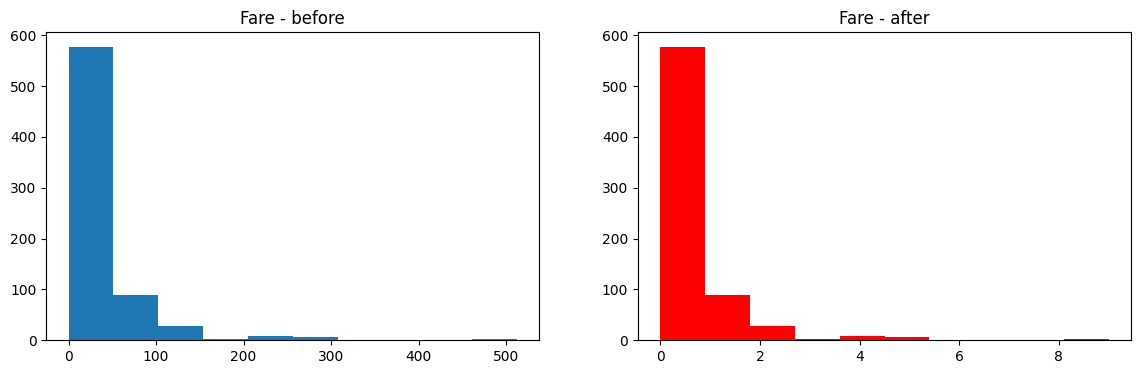

In [24]:
# apply discretization with 10 uniform bins and show effect + accuracy
discretize(10, 'uniform')

0.6359154929577465


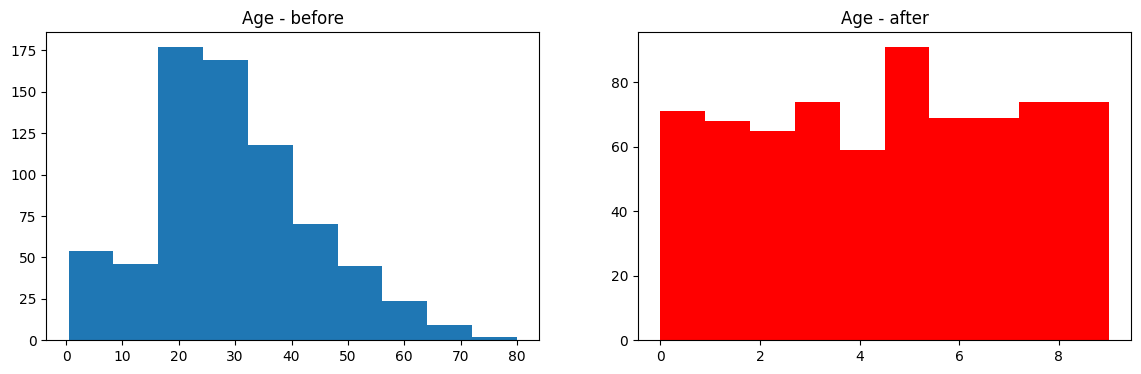

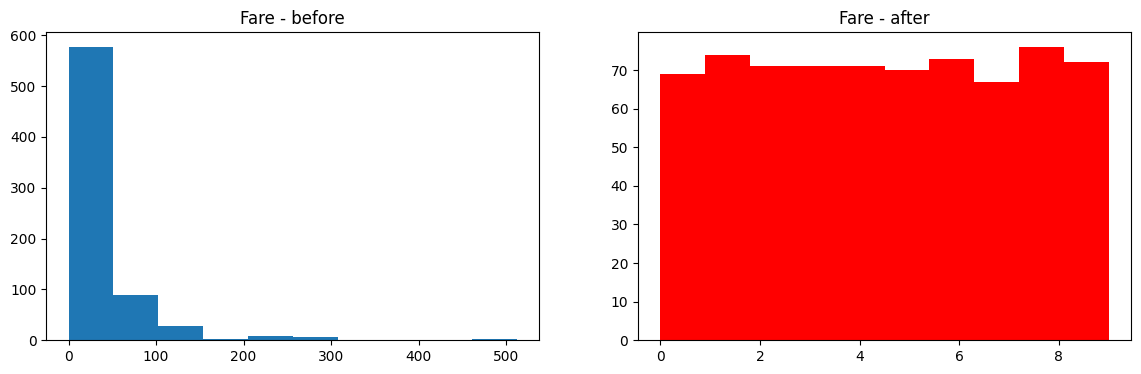

In [25]:
# apply discretization with 10 quantile bins and show effect + accuracy
discretize(10, 'quantile')

0.624706572769953


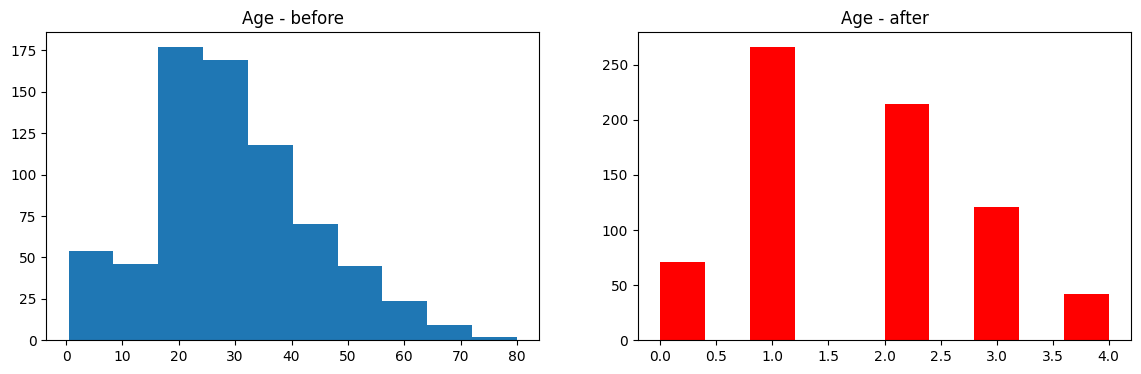

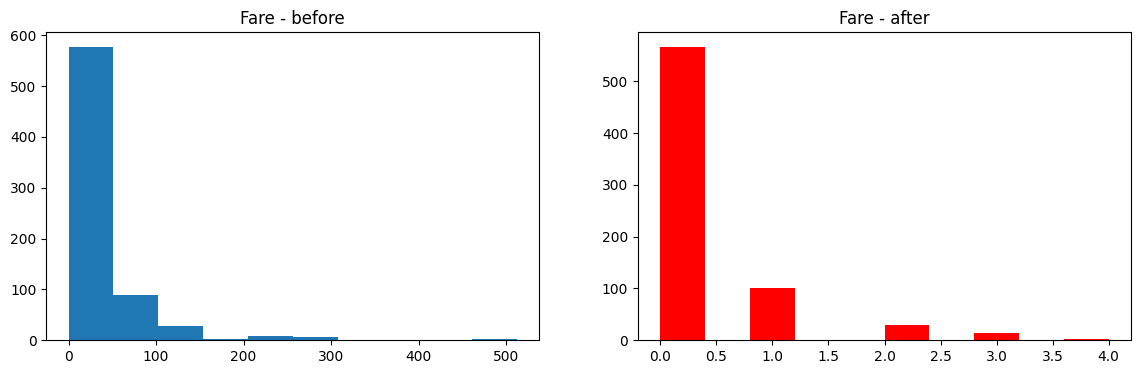

In [26]:
# apply discretization with 5 kmeans bins and show effect + accuracy
# kmeans groups values into clusters for binning
discretize(5, 'kmeans')